In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
import pyshtools as sht
import numpy as np

Loading SHTOOLS documentation


In [2]:
coeffs,errors,lmax = sht.SHReadError('EGM2008_to2190_ZeroTide.shm',2159)

In [3]:
coeffs.shape

(2, 2160, 2160)

In [3]:
# Setting this next coefficient to 1 gives the so-called "external" gravitational potential
# Setting it to zero gives the "disturbing" potential. 
coeffs[0,0,0] = 1.

OK. Visualizing the field, we see that it is utterly dominated by the centrifugal accelerations due to the rotating planet. This is what geophysicists usually get rid of via the "Latitude Correction" because it is essentially uninteresting for identifying the mass distributions. Physical geodesists, on the other hand, care a great deal about this because their primary interest is in determining the shape of the planet.

There are smaller longitudinal effects, due to the ellipsoidal (as opposed to spheroidal) shape of the Earth, but let's see how far we get by simply setting the (co)latitudinal coefficient to zero -- i.e. $C_{20}$ in the SH expansion.

This is probably way too crude for publication. We really should compute the latitude correction, and subtract that from the SH expansion. However, once we get to the _filtering_ part of filtered backprojection, it is very unlikely to matter.

In [3]:
#Keep it around for future reference/use...
C20 = coeffs[0,2,0]
print C20
coeffs[0,2,0] = 0.
#coeffs[:,2,:] = 0.

-0.000484165143791


In [3]:
grid    = sht.MakeGridDH(coeffs,sampling=2,csphase=1)

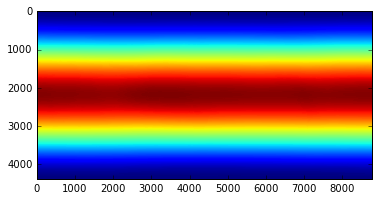

In [4]:
plt.imshow(grid)

In [7]:
print 360./(grid.shape[1]-1)

0.0410818212941


In [5]:
def J2n(n, J2 = 1.08263E-3, a=6378137., E = 522000.):
    ellip = E / a
    sgn = (-1)**(n+1)
    ans = (sgn*(3.*ellip**(2*n))/(((2.*n)+1.)*((2.*n)+3.))) *(1.-n+((5.*n)/(ellip**2))*J2)
    return ans
#for n in range(1,13):
#    print J2n(n)
# J2n Checked to be correct for n=1 and n = 2. 

def myDeltaCnm(n,m):
    """Computes the elliptical Earth *correction* terms to the SH expansion.
      
      The intent is to subtract what is returned from this function from the SH coeffs of V.      
    """
    if n == 0:
        # We are returning zero here because we don't want to perturb
        # whatever convention we have decided upon for C00.
        # IF we decide to keep the mass of the Earth in the calculation, this subtracts
        # zero from that value. IF we decide NOT to keep the mass of the Earth in, this still
        # subtracts zero from that value.
        return 0.
    elif (m == 0) and ((n % 2) == 0):
        # We have an even degree and zero order here
        # We need to correct the zonal coefficient by
        # *subtracting* this value from it.
        return -J2n(n)/np.sqrt((2.*n)+1)
    else:
        # All other cases, do not perturb the SH coefficient.
        return 0.

# A usage example:

for deg in range(0,12):
    mdcnm = myDeltaCnm(deg,0)
    print deg, (coeffs[0,deg,0] - mdcnm), coeffs[0,deg,0], coeffs[1,deg,0] - mdcnm, coeffs[1,deg,0]

0 0.0 0.0 0.0 0.0
1 0.0 0.0 0.0 0.0
2 -0.00048522507947 -0.000484165143791 -1.05993567934e-06 0.0
3 9.57161207093e-07 9.57161207093e-07 0.0 0.0
4 5.39961136717e-07 5.39965866639e-07 -4.7299223942e-12 0.0
5 6.86702913737e-08 6.86702913737e-08 0.0 0.0
6 -1.4995392792e-07 -1.49953927979e-07 5.8203137071e-17 0.0
7 9.05120844522e-08 9.05120844522e-08 0.0 0.0
8 4.94756003005e-08 4.94756003005e-08 4.88039090875e-21 0.0
9 2.80180753216e-08 2.80180753216e-08 0.0 0.0
10 5.33304381729e-08 5.33304381729e-08 2.26274126213e-25 0.0
11 -5.07683787086e-08 -5.07683787086e-08 0.0 0.0


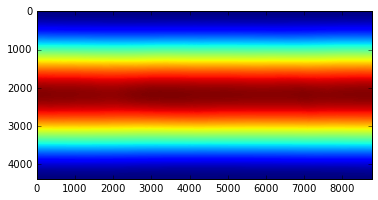

In [6]:
no_ellipsoid_coeffs = coeffs.copy()
for deg in range(0,9):
    mdcnm = myDeltaCnm(deg,0)
    no_ellipsoid_coeffs[0,deg,0] -= mdcnm
    
no_ellipsoid_grid = sht.MakeGridDH(no_ellipsoid_coeffs,sampling=2,csphase=1)
plt.imshow(no_ellipsoid_grid)

Correction for the "Normal gravity". In geodesy, the V potential includes a contribution from the spheroid. I believe that the spheroidal model we have the SH coefficients for is the GRS80 model (slightly different from the WGS84 model). 
Jekeli (2007) gives an expansion in SH coefficients of the spheroidal correction part in terms of even degrees:
$J_{2n} = (-1)^{n+1} \frac{}{}

This next function computes the distance from the North Pole on a sphere of radius $R_e$ to all points on a concentric sphere of radius $r_i$. 

Let $\theta$ = the co-latitude (ranging from 0 at the North Pole to $\pi$ at the South Pole).

Let $R_e$ be the radius of an external sphere with center at the origin. (The subscript e for either Earth or external...)

Let $r_i$ be the radius of an internal sphere concentric with the external one, with the vector ${\bf r}_i$ ending at an arbitrary point on the internal sphere. The length $|{\bf r}_i| = r_i$. We also assume that there is some mass located at ${\bf r}_i$. The distribution of these masses over all orientations of ${\bf r}_i$ and for all internal spheres is the object of our tomography. 

Let the $z$ axis be positive through the North Pole.

Let $r_a$ be the distance along the $z$ axis from the North Pole to the base of the vector perpendicular to the $z$ axis that ends at the position vector ${\bf r}_i$. Also let $r_b$ be the (perpendicular) distance from the $z$ axis to the position vector ${\bf r}_i$.

Finally, let $r_{pm}$ be the distance from the North Pole to a mass located at position vector ${\bf r}_i$.

Then $r_a = R_e - r_i \cos \theta$, $r_b = r_i \sin \theta$, and $r_{pm} = \sqrt{r_a^2 + r_b^2} = \sqrt{(R_e - r_i \cos \theta)^2 + (r_i \sin \theta)^2} = \sqrt{R_e^2 + r_i^2 - 2 r_i R_e \cos \theta}$.

In [3]:
def make_Rpm(R_e,r_i,co_lats,shp):
    rpm_1D = np.sqrt(-2.*r_i*R_e*np.cos(co_lats) + R_e**2 + r_i**2 )
    rpm_2D = np.zeros(shp,np.float64)
    rpm_2D[:,:] = rpm_1D[:,np.newaxis]
    
    return rpm_2D

In [4]:
# These are appropriate values for the GRS80 model
omega_earth = 7.292115e-5
a_earth = 6378137.
b_earth = 6356752.3141
GM_earth = 3.986005e14
f_earth = 0.003352810681183637418
pot_ref_geoid_earth = 6263686.0850E1

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [6]:
print sht.constant.r0_pot_earth

6378136.3


In [19]:
# These are appropriate values for the WGS84 model
omega_earth = 7.2921151467e-5
a_earth = 6378137.
GM_earth = 3.986004418e14
inverse_flattening = 298.257223563
f_earth = 1./inverse_flattening

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [7]:
grav = sht.MakeGravGridDH(coeffs,
                          gm = GM_earth,
                          r0 = a_earth,
                          omega=omega_earth,
                          a = a_earth,
                          f = f_earth,
                          normal_gravity = 1)

In [5]:
geoid = sht.MakeGeoidGridDH(coeffs,
                            r0pot = a_earth,
                            GM = GM_earth,
                            PotRef=pot_ref_geoid_earth,
                            omega=omega_earth,
                            a = a_earth,
                            f = f_earth,
                            order=2)

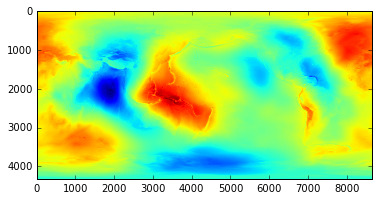

In [6]:
plt.imshow(geoid)

In [7]:
nlat,nlon = geoid.shape
dlat = 360. / nlat
lats = np.linspace(0. + (dlat / 2.), 360. - (dlat / 2.), nlat)
normal_gravs = [sht.NormalGravity(lat,GM_earth,omega_earth,a_earth,b_earth) for lat in lats]
ng = np.array(normal_gravs,np.float64)
#print normal_gravs

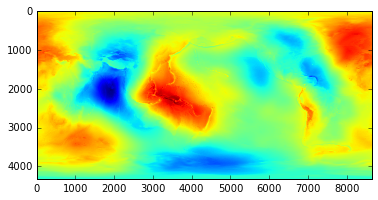

In [8]:
# Brun's formula
T = geoid * ng[:,np.newaxis]
fig = plt.figure()
plt.imshow(T)
fig.savefig('Timage.png')

In [9]:
T_SH = sht.SHExpandDH(T)

In [10]:
print T_SH.shape

(2, 2160, 2160)


In [27]:
anti_radial_deriv_op = -a_earth/np.arange(1.,gravity_disturbance_SH.shape[1]+1.,1.)

print anti_radial_deriv_op

[ -6.37813700e+06  -3.18906850e+06  -2.12604567e+06 ...,  -2.91372179e+03
  -2.91239132e+03  -2.91106207e+03]


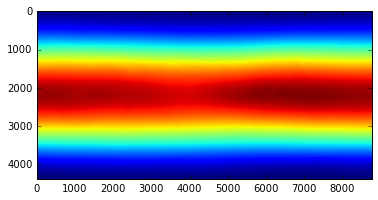

In [28]:
T_SH = gravity_disturbance_SH * anti_radial_deriv_op[np.newaxis,:,np.newaxis]

T_grid = sht.MakeGridDH(T_SH,sampling=2,csphase=1)

plt.imshow(T_grid)



**Old dead code only below here. Mostly preserved for examples of calling routines...**

Correction for the field due to the ellipsoid.

$J_{2n} = (-1)^{n+1} \frac{3 e^{2n}}{(2n+1)(2n+3)} (1-n+\frac{5n}{e^2}J_2)$

Here, e is **not** the base of the natural logarithms, but rather $e = E/a$, $a$ is the radius at the equator, and $E$ is the "linear ellipticity" or the distance from the centroid to the focus of the ellipse of revolution. For our purposes, we are trying E = 522km.

$$\delta C^{(a)}_{nm} = 0; n=0\\
                                C^{(a)}_{n0} - \frac{-J_n}{\sqrt{2n+1}}; n = 2,4,6...\\
                                C^{(a)}_{nm}; otherwise$$
                                
Where the seed of the recursion are measured numerical values (for GRS80):
$J_2 = 1.08263E-03$; $a = 6378137$; 





In [ ]:
coeffs = sht.SHCoeffs.from_file('EGM2008_to2190_TideFree',2190)

In [8]:
sht.MakeGridDH?

In [40]:
sht.constant.r0_pot_earth

array(6378136.3)

In [15]:
grid.min()

-1.047208727436478e-05

In [9]:
r0_pot_earth = sht.constant.r0_pot_earth
gm_earth = sht.constant.gm_earth
w0_mars = sht.constant.w0_mars

print r0_pot_earth,gm_earth,w0_mars

6378136.3 3.986004415e+14 12654875.0


In [17]:
geoid = sht.MakeGeoidGridDH (coeffs, r0_pot_earth, gm_earth, grid.mean())

In [17]:
geoid.shape

(4382, 8764)

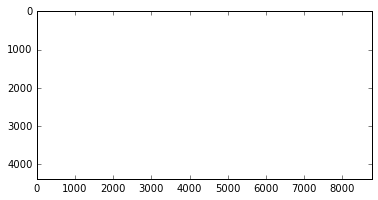

In [18]:
plt.imshow(geoid)

In [14]:
geoid.min()

nan

In [35]:
geoid.max()

nan

In [15]:
geoid.mean()

nan

In [19]:
sht.MakeGridDH?

In [3]:
print lmax

2190


In [11]:
co_lats = np.linspace(0.,np.pi,num=T.shape[0],endpoint=True)

In [27]:
rpm_2D = -make_Rpm(R_e = 6371000., r_i = 0.98*6371000., co_lats = co_lats, shp = T.shape)

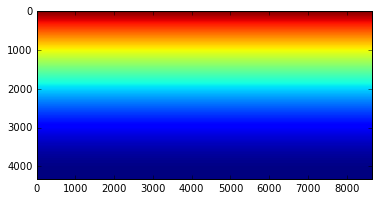

In [28]:
plt.imshow(rpm_2D)

In [11]:
class MyDHGrid(sht.classes.DHGrid):
    
    def __init__(self,array):
        self.nlat, self.nlon = array.shape
        if self.nlon == (2 * self.nlat):
            self.sampling = 2
        elif self.nlat == self.nlon:
            self.sampling = 1
        else:
            raise ValueError('input array with shape (nlat={:d},nlon={:d})\n' +
                             'it needs nlat=nlon or nlat=2*nlon'.format(self.nlat, self.nlon))
        self.data = array
        

rpm_dh2grid = MyDHGrid(rpm_2D)

In [9]:
%debug

> <ipython-input-8-78a40f7f5bd2>(11)__init__()
     10             raise ValueError('input array with shape (nlat={:d},nlon={:d})\n' +
---> 11                              'it needs nlat=nlon or nlat=2*nlon'.format(self.nlat, self.nlon))
     12         self.data = array

ipdb> p self.nlat
4382
ipdb> p 2*self.nlat
8764
ipdb> p self.nlon
8764
ipdb> q


In [29]:
rpm_2D_SH = sht.SHExpandDH(rpm_2D)

In [30]:
rpm_2D_SH.shape

(2, 2160, 2160)

In [31]:
kernel =  rpm_2D_SH[0,:,0]
print kernel.shape

(2160,)


In [71]:
coeffs.shape

(2, 2191, 2191)

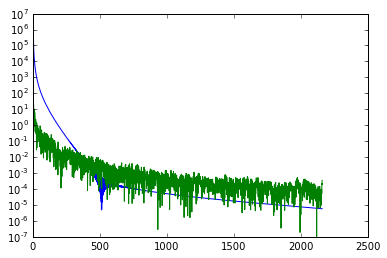

In [32]:
plt.semilogy(np.abs(kernel))
plt.semilogy(np.abs(T_SH[0,:,0]))


In [58]:
convolved = kernel[np.newaxis,:,np.newaxis] * T_SH

print convolved[:,0:5,0:5]
convolved[:,1,1] = 0.

[[[ -1.47112303e+08  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    -0.00000000e+00]
  [ -4.28041347e+07   5.97114100e+08   0.00000000e+00   0.00000000e+00
     0.00000000e+00]
  [ -1.29135025e+06   2.59862848e+07  -4.74894181e+07   0.00000000e+00
     0.00000000e+00]
  [  9.07657679e+06  -7.41217365e+06  -7.69813343e+06   2.60240530e+06
     0.00000000e+00]
  [ -2.38493350e+06   5.52489971e+06   1.12247936e+06   2.31052596e+05
    -2.84868300e+05]]

 [[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    -0.00000000e+00]
  [  0.00000000e+00  -2.96391987e+08   0.00000000e+00   0.00000000e+00
     0.00000000e+00]
  [  0.00000000e+00  -3.79957054e+07   1.74727559e+07   0.00000000e+00
     0.00000000e+00]
  [  0.00000000e+00   3.65769773e+07   1.19535115e+07   7.83368552e+05
     0.00000000e+00]
  [  0.00000000e+00  -3.10683586e+06  -9.78248907e+05   1.97505460e+06
     1.35025240e+06]]]


In [59]:
tomo_r1 = sht.MakeGridDH(convolved,sampling=2,csphase=1)

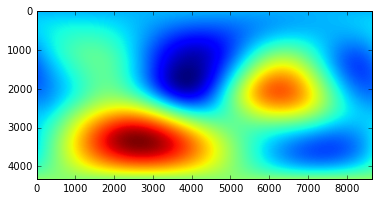

In [60]:
plt.imshow(tomo_r1)

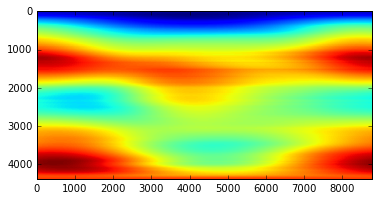

In [76]:
plt.imshow(tomo_r1)

In [23]:
ramp_filter = np.linspace(0.,1.,num=convolved.shape[1],endpoint=True)

cone_filter_2d = np.sqrt(np.outer(ramp_filter*ramp_filter,ramp_filter*ramp_filter))

In [61]:
filtered_convolved = cone_filter_2d[np.newaxis,:,:]* convolved

In [62]:
tomo_r1_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1)

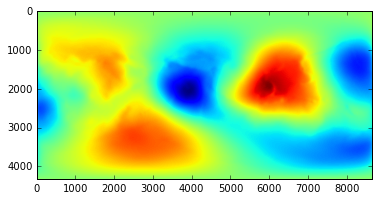

In [63]:
plt.imshow(tomo_r1_filtered)

In [10]:
omega = 2. * np.pi / (24.*60.*60.)
print omega
V_c = -(1./2.) * (omega**2) * (r0_pot_earth**2) * (np.sin(co_lats)**2)
print V_c.min()
print grid.max()

7.27220521664e-05
-107569.659005
0.000554780992829


In [102]:
print r0_pot_earth

6378136.3


In [12]:
G_Me = 3986004.415E8
Re_EGM08 = 6378136.3

In [14]:
V_c_unitless = V_c*Re_EGM08/G_Me


In [15]:
V_c_unitless.min()

-0.0017212573681435323

In [16]:
print coeffs[0,2,0]

-0.000484165143791


In [25]:
no_cetrifugal_grid = no_ellipsoid_grid -V_c_unitless[:,np.newaxis]

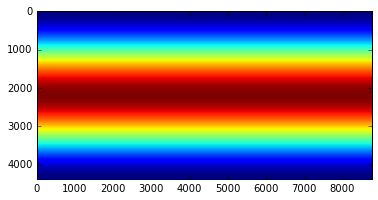

In [26]:
plt.imshow(no_cetrifugal_grid)